<a href="https://colab.research.google.com/github/anaaaraujoo/deepfake-detection/blob/main/HybridDeepfakeDetector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Hybrid deepfake detection (CNN-LSTM-Transformer Approach)**

In [18]:
# Installing all the necessary libraries and frameworks
!pip install -q tensorflow matplotlib seaborn scikit-learn opencv-python numpy pandas tqdm pytorch-lightning timm gdown

In [19]:
# Importing all the necessary libraries
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torchvision
from torch.utils import data as data
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torch.nn as nn
import tensorflow as tf
import keras
from keras import layers
from tensorflow.keras.layers import Input, TimeDistributed, Dense, LSTM, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications import Xception
from tensorflow.keras.utils import Sequence
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [20]:
# Downloading and unziping the dataset - CelebDF
from google.colab import drive
import zipfile
drive.mount('/content/drive')
dataset_path = '/content/drive/MyDrive/Celeb-DF.zip'
extract_path = '/content'
zip_ref = zipfile.ZipFile(dataset_path, 'r')
zip_ref.extractall(extract_path)
zip_ref.close()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Number of real videos on the training set: 408
Number of fake videos on the training set: 795
Real Samples: 


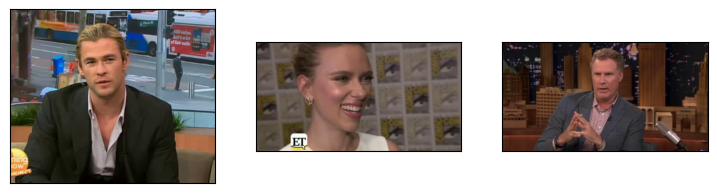

Fake Samples: 


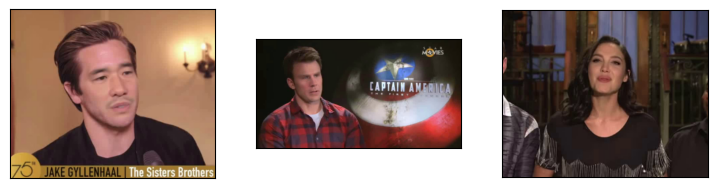

In [21]:
# Data analysis
# Plotting some samples for visual comprehension
real_path = '/content/Celeb-real'
yt_path = '/content/YouTube-real'
fake_path = '/content/Celeb-synthesis'

real_videos_samples = [os.path.join(real_path, f) for f in os.listdir(real_path) if f.endswith(".mp4")]
fake_videos_samples = [os.path.join(fake_path, f) for f in os.listdir(fake_path) if f.endswith(".mp4")]
yt_videos_samples = [os.path.join(yt_path, f) for f in os.listdir(yt_path) if f.endswith(".mp4")]

print(f'Number of real videos on the training set: {len(real_videos_samples) + len(yt_videos_samples)}')
print(f'Number of fake videos on the training set: {len(fake_videos_samples)}')

n = 3 # Samples to plot per class

def extract_first_frame(video_path):
  cap = cv2.VideoCapture(video_path)
  ret, frame = cap.read()
  cap.release()
  return frame

i = 1
print('Real Samples: ')
plt.rcParams['figure.figsize'] = [9, 9]
for video in real_videos_samples[:n]:
  ax = plt.subplot(3, n, i)
  frame = extract_first_frame(video)
  plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  i += 1
plt.show()

print('Fake Samples: ')
plt.rcParams['figure.figsize'] = [9, 9]
for video in fake_videos_samples[:n]:
  ax = plt.subplot(3, n, i)
  frame = extract_first_frame(video)
  plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  i += 1
plt.show()

In [25]:
# Dataset class
class CelebDF(Dataset):
  def __init__(self, video_paths, use_tensor=True, detect_faces_flag=True, max_frames=30):
    self.videos = video_paths
    self.detect_faces_flag = detect_faces_flag
    self.crop_faces_flag = detect_faces_flag
    self.max_frames = max_frames

    haar_cascade_url = 'https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml'
    haar_cascade_path = 'haarcascade_frontalface_default.xml'
    if not os.path.exists(haar_cascade_path):
        import urllib.request
        urllib.request.urlretrieve(haar_cascade_url, haar_cascade_path)
    self.face_cascade = cv2.CascadeClassifier(haar_cascade_path)

  def __len__(self):
    return len(self.videos)

  # Frame extractor
  def frame_extractor(self, video_path):
    frames = []
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
      print(f'Error opening video file: {video_path}')
      return np.array([])
    frame_count = 0
    while True:
      ret, frame = cap.read()
      if not ret or frame_count >= self.max_frames:
        break
      frame = cv2.resize(frame, (224, 224))
      frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
      frames.append(frame)
      frame_count += 1
    cap.release()
    return np.array(frames)

  # Face recognition
  def detect_faces(self, frames):
    processed_frames = []
    for frame in frames:
      gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
      faces = self.face_cascade.detectMultiScale(gray, 1.1, 4)
      if len(faces) > 0:
        largest_face = max(faces, key=lambda x: x[2] * x[3])
        x, y, w, h = largest_face
        face = cv2.resize(frame[y:y+h, x:x+w], (224, 224))
        processed_frames.append(face)
      else:
        processed_frames.append(np.zeros((224, 224, 3), dtype=np.uint8))
    return np.array(processed_frames) if processed_frames else np.array([])

  # Each output is in TensorFlow format
  def __getitem__(self, idx):
    video_path = self.videos[idx]
    frames = self.frame_extractor(str(video_path))
    if (len(frames) == 0):
      return tf.zeros((1, 224, 224, 3), dtype=tf.float32), tf.constant(0, dtype=tf.int32)

    if self.crop_faces_flag:
      frames_crops = self.detect_faces(frames)
      if frames_crops.size > 0:
        frames = frames_crops
      else:
        return tf.zeros((1, 3, 224, 224), dtype=tf.float32), tf.constant(0, dtype=tf.int32)

    frames = tf.convert_to_tensor(frames, dtype=tf.float32) / 255.0
    label = tf.constant(1 if "real" in str(video_path) else 0, dtype=tf.int32)
    return frames, label

  def generator(self):
    for video_path in self.videos:
      frames = self.frame_extractor(str(video_path))
      if (len(frames) == 0):
        yield tf.zeros((1, 224, 224, 3), dtype=tf.float32), tf.constant(0, dtype=tf.int32)
        continue
      if self.crop_faces_flag:
        frames_crops = self.detect_faces(frames)
        if frames_crops.size > 0:
          frames = frames_crops
        else:
          yield tf.zeros((1, 3, 224, 224), dtype=tf.float32), tf.constant(0, dtype=tf.int32)
          continue
      frames = tf.convert_to_tensor(frames, dtype=tf.float32) / 255.0
      label = tf.constant(1 if "real" in str(video_path) else 0, dtype=tf.int32)
      yield frames, label

In [26]:
# Dividing the data in the train/val/test split
# Extracting videos from the .txt file
def read_split_list(txt_file):
    with open(txt_file, "r") as f:
        videos = [line.strip() for line in f.readlines()]
    return videos

real_videos_root = Path("/content/Celeb-real")
yt_videos_root = Path("/content/YouTube-real")
fake_videos_root = Path("/content/Celeb-synthesis")
test_videos_root = Path("/content/List_of_testing_videos.txt")

real_videos = list(real_videos_root.rglob("*.mp4"))
yt_videos = list(yt_videos_root.rglob("*.mp4"))
fake_videos = list(fake_videos_root.rglob("*.mp4"))
test_videos  = read_split_list(test_videos_root)

all_videos = real_videos + fake_videos + yt_videos
print(f"Total number of videos: {len(all_videos)}")

# Create labels for the videos: 0 -> real, 1 -> fake
train_labels = [1] * (len(real_videos) + len(yt_videos)) + [0] * len(fake_videos)

train_videos, val_videos, train_labels, val_labels = train_test_split(
    all_videos, train_labels,
    test_size = 0.15,
    random_state = 42,
    stratify = train_labels
)

train_data = CelebDF(train_videos, detect_faces_flag=True)
val_data   = CelebDF(val_videos, detect_faces_flag=True)
test_data  = CelebDF(test_videos, detect_faces_flag=True)

train_ds = tf.data.Dataset.from_generator(train_data.generator, output_types=(tf.float32, tf.int32), output_shapes=((30, 224, 224, 3), ()))
val_ds = tf.data.Dataset.from_generator(val_data.generator, output_types=(tf.float32, tf.int32), output_shapes=((30, 224, 224, 3), ()))
test_ds = tf.data.Dataset.from_generator(test_data.generator, output_types=(tf.float32, tf.int32), output_shapes=((30, 224, 224, 3), ()))

print(f"Number of training videos: {len(train_data)}")
print(f"Number of validation videos: {len(val_data)}")
print(f"Number of testing videos: {len(test_data)}")

Instructions for updating:
Use output_signature instead
Instructions for updating:
Use output_signature instead


Total number of videos: 1203
Number of training videos: 1022
Number of validation videos: 181
Number of testing videos: 100


Video; /content/Celeb-synthesis/id2_id6_0004.mp4
Label: 0
Frames: (30, 224, 224, 3)


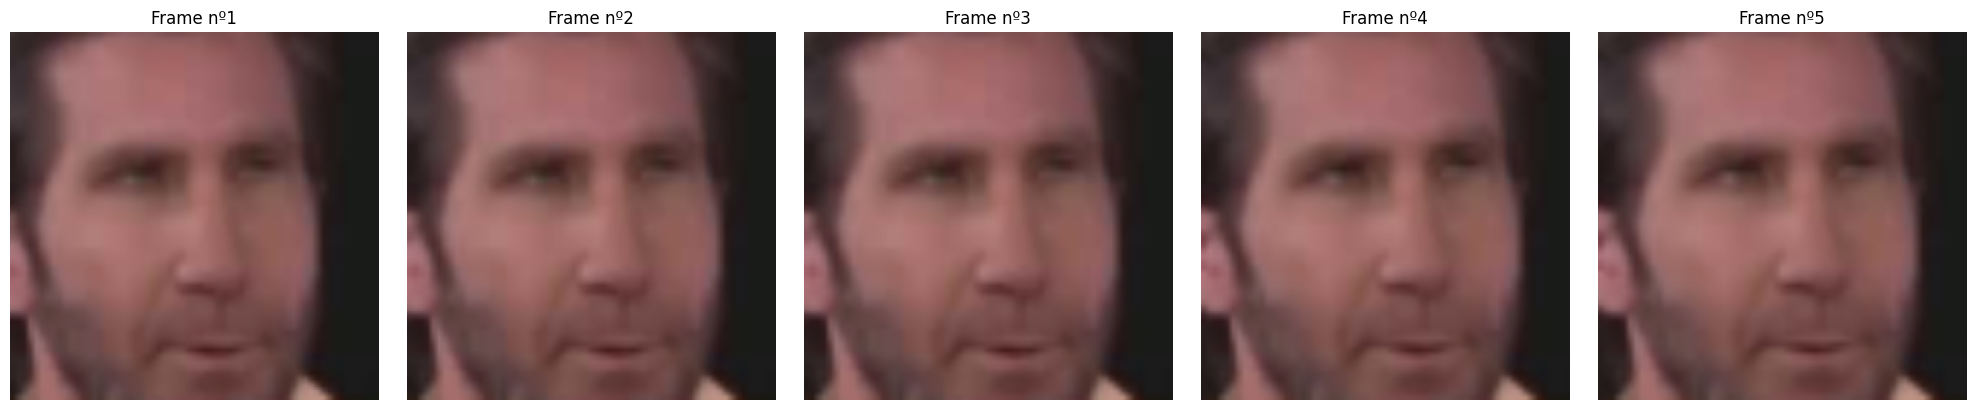

In [27]:
# Testing the frame extractor and the face recognition functions
max_display = 5
frames, label = train_data[1]
print(f'Video; {train_data.videos[1]}')
print(f'Label: {label}')
print(f'Frames: {frames.shape}')
fig, axes = plt.subplots(1, max_display, figsize=(4 * max_display, 4))
for i in range (max_display):
  axes[i].imshow(frames[i])
  axes[i].set_title(f'Frame nº{i+1}')
  axes[i].axis('off')
plt.tight_layout()
plt.show()

In [28]:
# CNN-LSTM Model
# The Xception model only outputs features, that is why the fully connected top layer (that
# predicts classes scores) is left out
def cnn_lstm_model():
  cnn_backbone = Xception(
      weights='imagenet',
      include_top=False,
      input_shape=(224, 224, 3)
  )
  cnn_backbone.trainable = True # Allow finetuning
  video_input = Input(shape=(30, 224, 224, 3))
  cnn_features = TimeDistributed(cnn_backbone)(video_input)
  cnn_features = TimeDistributed(Flatten())(cnn_features)
  lstm_features = lstm_features = LSTM(128)(cnn_features)
  lstm_features = Dropout(0.5)(lstm_features)
  output = Dense(1, activation='sigmoid')(lstm_features)

  model = Model(inputs=video_input, outputs=output)
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  model.summary()
  return model